In [1]:
import numpy as np
import healpy as hp
import pandas as pd
from pylab import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase

###################################################################################

def superpixel(subpix, nside_subpix, nside_superpix):
    """
    Return the indices of the super-pixels which contain each of the sub-pixels.
    """
    if nside_subpix == nside_superpix:
        return subpix
    theta, phi = hp.pix2ang(nside_subpix, subpix)
    return hp.ang2pix(nside_superpix, theta, phi)



def subpixel(superpix, nside_superpix, nside_subpix):
    """
    Return the indices of sub-pixels (resolution nside_subpix) within
    the super-pixel with (resolution nside_superpix).
    """
    if nside_superpix == nside_subpix:
        return superpix
    vec = hp.pix2vec(nside_superpix, superpix)
    radius = np.degrees(2. * hp.max_pixrad(nside_superpix))
    subpix = query_disc(nside_subpix, vec, radius=radius)
    pix_for_subpix = superpixel(subpix, nside_subpix, nside_superpix)
    # Might be able to speed up array indexing...
    return subpix[pix_for_subpix == superpix]

######################################################################################

for k in range(3):
    f = 'data/quasar_sample_' + str(k+1) + '.csv'
    df0 = pd.read_csv(f)

    fd1 = df0[(df0.b>=40)]
    fd2 = df0[(df0.b<=0)]
    fd3 = fd2[(fd2.b<=-60)]

    fd4 = pd.concat([fd1, fd3])
    fd4.reset_index(inplace = True, drop = True)

    l = fd4['l'].to_numpy()
    b = fd4['b'].to_numpy()

    l_rad = np.radians(l)
    b_rad = np.radians(b)

    # angular distance from (l=0, b=0)
    cos_theta = np.cos(b_rad) * np.cos(l_rad)
    theta_rad = np.arccos(cos_theta)
    theta_deg = np.degrees(theta_rad)

    # Apply circular mask of radius 68.6°
    mask = theta_deg > 68.6
    fd5 = fd4[mask].reset_index(drop=True)
    r = fd5['r'].to_numpy()    
    th = fd5['theta'].to_numpy()
    ph = fd5['phi'].to_numpy()


    Nside=64                   # nside of the subpixel
    Npix=hp.nside2npix(Nside)

    nside = 8                  # nside of the superpixel
    super_pix = hp.nside2npix(nside)   

    m=np.zeros(Npix, dtype= int)
    for i in range(len(r)):
        px=hp.ang2pix(Nside, th[i], ph[i])
        m [px]+=1

    sp=np.zeros(Npix)
    for j in range(Npix):
        sp[j]= superpixel(j, Nside, nside)               

    # Stack the arrays column-wise
    data1 = np.column_stack((sp,m))
    df = pd.DataFrame(data1, columns=['spp', 'mm'])
    P=[]
    for j in range(super_pix):
        fd = df[df.spp == j]
        fd.reset_index(inplace = True, drop = True)
        f = (len(fd[fd.mm!=0]))/len(fd)
        if(f>=0.90):
            P.append(j)

    p = np.array(P)
    df1 = pd.DataFrame(data=p)
    f1 = 'mask2/non_zero_pix_id_' + str(k+1) + '.dat'

    df1.to_csv(f1,sep='\t',header = None,index = False)
    
        
    op = 'mask2/masked_sample_' + str(k+1) + '.dat'

    f2=open(op, 'w')
    for i in range(len(r)):
        px=hp.ang2pix(8, th[i], ph[i])
        for j in range(len(p)):
            if(px==p[j]):
                f2.write("%f\t%f\t%f\n"%(r[i],th[i],ph[i]))

    f2.close()  


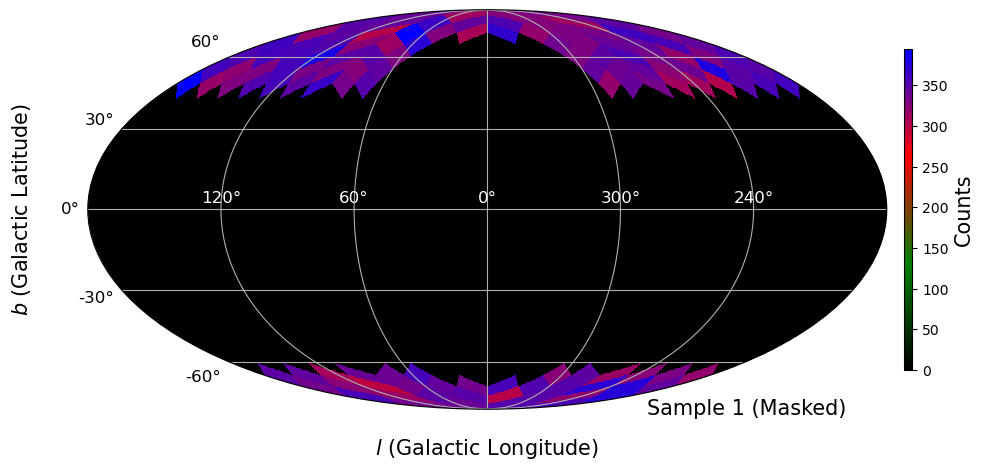

In [2]:
#################################################################################################

# Visualization of the masked data of sample 1

df_ = pd.read_csv("mask2/masked_sample_1.dat",sep="\t",header = None)

df_.columns = ['r','th','ph']
th2 = df_['th'].to_numpy()
ph2 = df_['ph'].to_numpy()

m1 = np.zeros(super_pix)
for j in range(len(th2)):
    px1=hp.ang2pix(nside,th2[j],ph2[j])
    
    m1[px1] += 1
    
m1min, m1max = np.min(m1),np.max(m1)

custom_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["black","green","red","blue"])
hp.projview(m1, coord=["G"], cbar=False, cmap=custom_cmap, graticule=True,
            graticule_labels=True, projection_type="mollweide", 
            longitude_grid_spacing=60, latitude_grid_spacing=30, xtick_label_color='white', 
            ytick_label_color='black', graticule_color=None)

plt.xlabel(r"$l$ (Galactic Longitude)", fontsize=15, labelpad=20)  
plt.ylabel(r"$b$ (Galactic Latitude)", fontsize=15, labelpad=20) 
plt.text(0.7, 0.00, "Sample 1 (Masked)", fontsize=15, color='black',
         ha='left', va='center', transform=plt.gca().transAxes)
norm = Normalize(vmin=np.min(m1), vmax=np.max(m1))
cax = plt.axes([1.0, 0.2, 0.01, 0.6])  
color_bar = ColorbarBase(cax, cmap=custom_cmap, norm=norm, orientation='vertical')
color_bar.set_label('Counts', fontsize=15)


plt.savefig('../plots/masked2_map_sample1.pdf', dpi=200, bbox_inches='tight')

plt.show()